In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from keras_preprocessing.image import ImageDataGenerator
from gm_networks import unet_model
import gm_first_cgan as cgan
from utils import create_dataset_from_one_image

In [2]:
PARENT_PATH = 'models/256_inputs/f0002'
# Model/training hyperparameters
INPUT_SHAPE = (256, 256, 3)
CROPPING_MODE = 'random_patches'  # (copy-paste a mode from: independent_patches, overlapped_patches, random_patches)
TRAIN_IMAGES_NUMBER = 640 # required only for 'random_patches' mode
PATCHES_STEP = None  # required only for 'overlapped_patches' mode
INITIAL_FILTERS = 80
BATCH_SIZE = 1
EPOCHS = 100
LEARNING_RATE = 0.0002

In [3]:
# Load the initial input and output images
x_initial_train = plt.imread('datasets/train/0_full_images/101-INPUT.jpg').astype('float32')[650:-550]
y_initial_train = plt.imread('datasets/train/0_full_images/101-OUTPUT-GT.png')[650:-550]
x_initial_valid = plt.imread('datasets/validation/0_full_images/201-INPUT.jpg').astype('float32') [500:-50]
y_initial_valid = plt.imread('datasets/validation/0_full_images/201-OUTPUT-GT.png')[500:-50]

In [5]:
# Create a dataset with the selected cropping mode
x_train, y_train = create_dataset_from_one_image(x_initial_train, 
                                                 y_initial_train, 
                                                 INPUT_SHAPE[0], 
                                                 mode=CROPPING_MODE, 
                                                 new_images_number=TRAIN_IMAGES_NUMBER, 
                                                 patches_step=PATCHES_STEP)

training_images_number = x_train.shape[0]

Crops creation with mode "random_patches" has been started.
New dataset shapes:
 - Input data = (640, 256, 256, 3)
 - Target data = (640, 256, 256, 1)


In [6]:
# create a validation dataset
x_valid, y_valid = create_dataset_from_one_image(x_initial_valid, 
                                                 y_initial_valid, 
                                                 INPUT_SHAPE[0], 
                                                 mode='independent_patches')

valid_images_number = x_valid.shape[0]

# select a subset from the validation dataset equal to 33% of the training dataset
# NOTE: If 0.33 * training_images_number > valid_images_number, then an Index Error is raised
val_data_size = training_images_number // 3
perm = np.random.permutation(valid_images_number)
x_valid = x_valid[perm][:val_data_size]
y_valid = y_valid[perm][:val_data_size]

print(x_valid.shape)

Crops creation with mode "independent_patches" has been started.
New dataset shapes:
 - Input data = (782, 256, 256, 3)
 - Target data = (782, 256, 256, 1)
(213, 256, 256, 3)


In [7]:
# Create dictionaries with the alterations to be used for the data augmentation operations for inputs and outputs
""""
NOTE: It is important to use exact the same values for the parameters in both dictionaries. 
The reason why we create 2 dictionaries instead of a common one is because  we want to add the 
preprocessing function for the output masks (this function sets all the pixel values of the mask to 0 or 1. 
While the initial ground truth images are binary, after the data augmentation operations, such as rotations and 
shifts, pixels with intermediate values are appeared due to interpolation)
"""
x_datagen_args = dict(
    rotation_range=25, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

y_datagen_args = x_datagen_args.copy()
y_datagen_args['preprocessing_function'] = lambda x: np.where(x>0, 1, 0).astype(x.dtype)

In [8]:
# Instatiate the generators
x_datagen = ImageDataGenerator(**x_datagen_args)
y_datagen = ImageDataGenerator(**y_datagen_args)

# Setting the same seed number for both generators leads to the same random alterations for both generators
seed = 19
x_datagen.fit(x_train, augment=True, seed=seed)
y_datagen.fit(y_train, augment=True, seed=seed)

x_train_generator = x_datagen.flow(x_train, seed=seed, batch_size=BATCH_SIZE)
y_train_generator = y_datagen.flow(y_train, seed=seed, batch_size=BATCH_SIZE)

train_generator = zip(x_train_generator, y_train_generator)

0


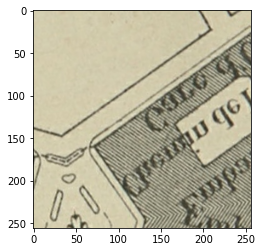

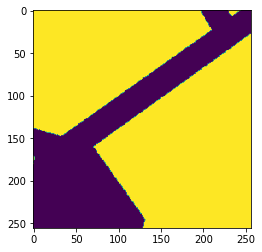

640


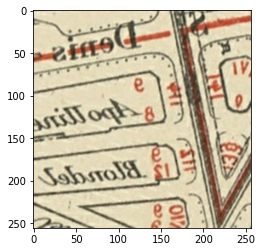

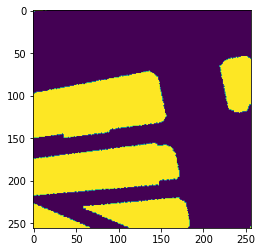

In [10]:
for step, (inp, tar) in enumerate(train_generator):
    if step == 0:
        print(step)
        plt.imshow(inp[0].astype('uint8'))
        plt.show()
        plt.imshow(tar[0])
        plt.show()
        
    if step == 640:
        print(step)
        plt.imshow(inp[0].astype('uint8'))
        plt.show()
        plt.imshow(tar[0])
        plt.show()
        break
    

In [ ]:
training_images_number = x_train.shape[0]
steps_per_epoch = int(training_images_number / BATCH_SIZE)

In [ ]:
discriminator = cgan.build_discriminator()
cgan.compile_discriminator(discriminator)
generator = cgan.build_generator()
gan = cgan.build_gan(generator, discriminator, input_shape=INPUT_SHAPE)
cgan.compile_gan(gan)

In [ ]:
if not os.path.exists(PARENT_PATH):
    os.makedirs(PARENT_PATH)

model_name = f'cgan_input{INPUT_SHAPE[0]}_filters{INITIAL_FILTERS}_images{x_train.shape[0]}_{CROPPING_MODE}_optAdam_lr{"{:0.4f}".format(gan.optimizer.lr.value().numpy())}_eps{EPOCHS}' #TODO: loss and metric'
model_path = os.path.join(PARENT_PATH, model_name)

In [ ]:
im_to_predict_on_training = np.expand_dims(x_initial_train[3700:4212, 2450:2962], 0)
gt_to_show_on_training = y_initial_train[3700:4212, 2450:2962]
predicted_on_train_path = os.path.join(model_path, 'sample_predictions_while_training')
os.makedirs(predicted_on_train_path)

history = cgan.train([x_train_generator, y_train_generator],
                     generator,
                     discriminator,
                     gan,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS,
                     steps_per_epoch=steps_per_epoch,
                     impair_for_predictions = [im_to_predict_on_training, gt_to_show_on_training],
                     path_to_save_predictions = predicted_on_train_path
                    )

In [ ]:
generator.save(model_path)
np.save(os.path.join(model_path, 'history'), history)

In [ ]:
gan.save(os.path.join(model_path, 'gan'))

In [ ]:
# Define and compile the model
model = unet_model(input_shape=INPUT_SHAPE, initial_filters=INITIAL_FILTERS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
if not os.path.exists(PARENT_PATH):
    os.makedirs(PARENT_PATH)

model_name = f'unet_input{INPUT_SHAPE[0]}_filters{INITIAL_FILTERS}_images{x_train.shape[0]}_{CROPPING_MODE}_optAdam_lr{"{:0.4f}".format(model.optimizer.lr.value().numpy())}_eps{EPOCHS}' #TODO: loss and metric'
model_path = os.path.join(PARENT_PATH, 'Unet', model_name)

tensorboard = TensorBoard(log_dir=os.path.join(PARENT_PATH, 'Unet', f'logs/{model_name}'))

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch, 
                    epochs=EPOCHS,
                    validation_data=(x_valid, y_valid),
                    callbacks=[tensorboard]
                   )

In [ ]:
# save the model and history of the training (loss, accuracy)
model.save(model_path)
np.save(os.path.join(model_path, 'history'), history.history)

In [ ]:
model.summary()